In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150

In [2]:
pudl_engine  = pudl.db_connect_pudl()

### Pulling the required tables

In [3]:
# Convert the generation_eia923 table into a dataframe
g9 = analysis.simple_select('generation_eia923', pudl_engine)
# Get yearly net generation by plant_id, year and generator_id
g9_summed = analysis.yearly_sum_eia(g9, 'net_generation_mwh')
g9_summed.reset_index(inplace=True)

In [4]:
# Convert the generators_eia860 table into a dataframe
g8 = analysis.simple_select('generators_eia860', pudl_engine)

# In order to use the energy source associated with each generator
g8_es = g8[['plant_id','generator_id', 'energy_source_1']]
g8_es = g8_es.rename(columns={'energy_source_1': 'energy_source'})
g8_es.drop_duplicates(['plant_id','generator_id'], inplace=True)

# In order to use the capacity of each generator
g8 = g8[['plant_id','generator_id','nameplate_capacity_mw','summer_capacity_mw','winter_capacity_mw','year']]
g8.rename(columns={'year': 'report_date'},inplace=True)

In [5]:
# # Cheating to duplicate 2015 EIA860 capacity factor data for 2016:
g8_2016 = g8.loc[g8['report_date'] == 2015]
g8_2016.report_date.replace([2015], [2016], inplace=True)
g8 = g8_2016.append(g8)

/home/alana/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [6]:
# Convert the fuel_receipts_costs_eia923 table into a dataframe
frc9 = analysis.simple_select('fuel_receipts_costs_eia923', pudl_engine)
frc9['fuel_cost'] = (frc9['fuel_quantity'] * frc9['average_heat_content'] * frc9['fuel_cost_per_mmbtu'])

In [7]:
# Get yearly fuel cost by plant_id, year and energy_source
frc9_summed = analysis.yearly_sum_eia(frc9 , 'fuel_cost', columns=['plant_id','report_date','energy_source'])
frc9_summed = frc9_summed.reset_index()

In [8]:
frc9_summed.head()

,plant_id,report_date,energy_source,fuel_cost
0,3,2009,BIT,3.019373e+08
1,3,2009,NG,1.881205e+08
2,3,2010,BIT,3.124745e+08
3,3,2010,NG,2.463235e+08
4,3,2011,BIT,2.025195e+08


In [9]:
# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)

In [10]:
# Convert the boiler_generator_assn_eia860 table into a dataframe
bga8 = analysis.simple_select('boiler_generator_assn_eia860', pudl_engine)
bga8.drop(['id','operator_id'],axis=1, inplace=True)

### Generating Capacity Factor

In [11]:
# merge the generation and capacity to calculate capacity factor
capacity_factor = g9_summed.merge(g8, on=['plant_id','generator_id','report_date'])
capacity_factor['capacity_factor'] =\
            capacity_factor['net_generation_mwh']/(capacity_factor['nameplate_capacity_mw']*8760)

In [12]:
# Remove unrealistic capacity factors: < 0 or > 1.5
capacity_factor = capacity_factor[capacity_factor.capacity_factor > 0]
capacity_factor = capacity_factor[capacity_factor.capacity_factor <= 1.5]

### Generating Fuel Cost

In [13]:
# Merge the generation table with the generator table to include energy_source
net_gen = g9_summed.merge(g8_es, how='left', on=['plant_id','generator_id'])
fuel_cost_per_mwh = net_gen.merge(frc9_summed,how='left',on=['plant_id','report_date','energy_source'])

In [14]:
# Sum the net generation by fuel type and year for each plant to calculation proportion of generation by each generator
net_gen_by_energy = fuel_cost_per_mwh.groupby(['plant_id', 'report_date', 'energy_source'])[["net_generation_mwh"]].sum()
net_gen_by_energy = net_gen_by_energy.reset_index()
fuel_cost_per_mwh = fuel_cost_per_mwh.merge(net_gen_by_energy, how='left', on=['plant_id', 'report_date', 'energy_source'])

In [15]:
# Calculate proportion of annual plant generation by each generator
fuel_cost_per_mwh['proportion_generation_by_gen'] = (fuel_cost_per_mwh.net_generation_mwh_x)/(fuel_cost_per_mwh.net_generation_mwh_y)
del fuel_cost_per_mwh['net_generation_mwh_y']
fuel_cost_per_mwh.rename(columns={'net_generation_mwh_x': 'net_generation_mwh'}, inplace=True)

In [16]:
# Calculate cost of fuel by generator
fuel_cost_per_mwh['fuel_cost_by_generator'] = fuel_cost_per_mwh['fuel_cost']*fuel_cost_per_mwh['proportion_generation_by_gen']

# Calculate fuel cost per mwh - will be the same for generators of same energy_source each year
fuel_cost_per_mwh['fuel_cost_per_mwh'] = fuel_cost_per_mwh['fuel_cost_by_generator'] / fuel_cost_per_mwh['net_generation_mwh']
fuel_cost_per_mwh.head(8)

,plant_id,report_date,generator_id,net_generation_mwh,energy_source,fuel_cost,proportion_generation_by_gen,fuel_cost_by_generator,fuel_cost_per_mwh
0,3,2009,1,221908.0,BIT,3.019373e+08,0.027594,8.331567e+06,37.545140
1,3,2009,2,394031.0,BIT,3.019373e+08,0.048997,1.479395e+07,37.545140
2,3,2009,3,1286393.0,BIT,3.019373e+08,0.159960,4.829781e+07,37.545140
3,3,2009,4,1626547.0,BIT,3.019373e+08,0.202257,6.106894e+07,37.545140
4,3,2009,5,4513101.0,BIT,3.019373e+08,0.561193,1.694450e+08,37.545140
5,3,2009,A1ST,1122697.0,NG,1.881205e+08,0.520628,9.794072e+07,87.237002
6,3,2009,A2ST,1033733.0,NG,1.881205e+08,0.479372,9.017977e+07,87.237002
7,3,2010,1,435334.0,BIT,3.124745e+08,0.055567,1.736342e+07,39.885273


### Generating Heat Rate

In [17]:
bg = bf9_summed.merge(bga8,how='left',on=['plant_id','boiler_id'])

# Get yearly fuel_consumed_mmbtu by plant_id, year and generator_id
bg_gb = bg.groupby(by=['plant_id','report_date','generator_id'])
bg_summed = bg_gb.agg({'fuel_consumed_mmbtu':np.sum})
bg_summed.reset_index(inplace=True)

heat_rate = bg_summed.merge(g9_summed,how='left',on=['plant_id', 'report_date', 'generator_id'])
heat_rate['heat_rate_mmbtu_mwh'] = heat_rate['fuel_consumed_mmbtu'] / heat_rate['net_generation_mwh']

### Merge fields together

In [18]:
mcoe_by_generator = fuel_cost_per_mwh.merge(heat_rate,on=['plant_id','report_date','generator_id'])

In [19]:
mcoe_by_generator = mcoe_by_generator.merge(capacity_factor, on=['plant_id','report_date','generator_id'])

In [20]:
mcoe_by_generator.head()

,plant_id,report_date,generator_id,net_generation_mwh_x,energy_source,fuel_cost,proportion_generation_by_gen,fuel_cost_by_generator,fuel_cost_per_mwh,fuel_consumed_mmbtu,net_generation_mwh_y,heat_rate_mmbtu_mwh,net_generation_mwh,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
0,3,2011,1,312130.0,BIT,2.025195e+08,0.067070,1.358305e+07,43.517289,7.130630e+06,312130.0,22.845065,312130.0,153.1,138.0,138.0,0.232732
1,3,2011,2,191475.0,BIT,2.025195e+08,0.041144,8.332473e+06,43.517289,4.572941e+06,191475.0,23.882708,191475.0,153.1,137.0,137.0,0.142769
2,3,2011,3,710069.0,BIT,2.025195e+08,0.152579,3.090028e+07,43.517289,1.502996e+07,710069.0,21.166900,710069.0,272.0,249.0,249.0,0.298008
3,3,2011,4,1175685.0,BIT,2.025195e+08,0.252631,5.116262e+07,43.517289,2.393865e+07,1175685.0,20.361445,1175685.0,403.7,362.0,362.0,0.332451
4,3,2011,5,2264413.0,BIT,2.025195e+08,0.486576,9.854112e+07,43.517289,4.611200e+07,2264413.0,20.363777,2264413.0,788.8,726.5,726.5,0.327706


In [21]:
mcoe_by_generator.drop('net_generation_mwh_y', axis=1, inplace=True)
mcoe_by_generator.drop('net_generation_mwh_x', axis=1, inplace=True)
mcoe_by_generator.drop('fuel_cost', axis=1, inplace=True)

# Filter to include only plants >= 50 MW

In [22]:
# Now, let's grab only those plants larger than 50MW
mcoe_by_generator = mcoe_by_generator[mcoe_by_generator['nameplate_capacity_mw']>=50]

### Let's look at some data

In [23]:
mcoe_by_generator[mcoe_by_generator['plant_id'] == 3]

,plant_id,report_date,generator_id,energy_source,proportion_generation_by_gen,fuel_cost_by_generator,fuel_cost_per_mwh,fuel_consumed_mmbtu,heat_rate_mmbtu_mwh,net_generation_mwh,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
0,3,2011,1,BIT,0.067070,1.358305e+07,43.517289,7.130630e+06,22.845065,312130.0,153.1,138.0,138.0,0.232732
1,3,2011,2,BIT,0.041144,8.332473e+06,43.517289,4.572941e+06,23.882708,191475.0,153.1,137.0,137.0,0.142769
2,3,2011,3,BIT,0.152579,3.090028e+07,43.517289,1.502996e+07,21.166900,710069.0,272.0,249.0,249.0,0.298008
3,3,2011,4,BIT,0.252631,5.116262e+07,43.517289,2.393865e+07,20.361445,1175685.0,403.7,362.0,362.0,0.332451
4,3,2011,5,BIT,0.486576,9.854112e+07,43.517289,4.611200e+07,20.363777,2264413.0,788.8,726.5,726.5,0.327706
5,3,2011,A1ST,NG,0.502827,1.200333e+08,85.891767,4.024245e+05,0.287961,1397495.0,195.2,173.0,192.0,0.817271
6,3,2011,A2ST,NG,0.497173,1.186836e+08,85.891767,3.467116e+05,0.250916,1381781.0,195.2,173.0,192.0,0.808082
7,3,2012,1,BIT,0.028595,8.069661e+06,53.054275,3.486280e+06,22.920672,152102.0,153.1,138.0,138.0,0.113411
8,3,2012,2,BIT,0.023201,6.547428e+06,53.054275,2.987908e+06,24.211231,123410.0,153.1,137.0,137.0,0.092018
9,3,2012,3,BIT,0.093353,2.634447e+07,53.054275,1.056941e+07,21.285395,496557.0,272.0,249.0,249.0,0.208399


/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


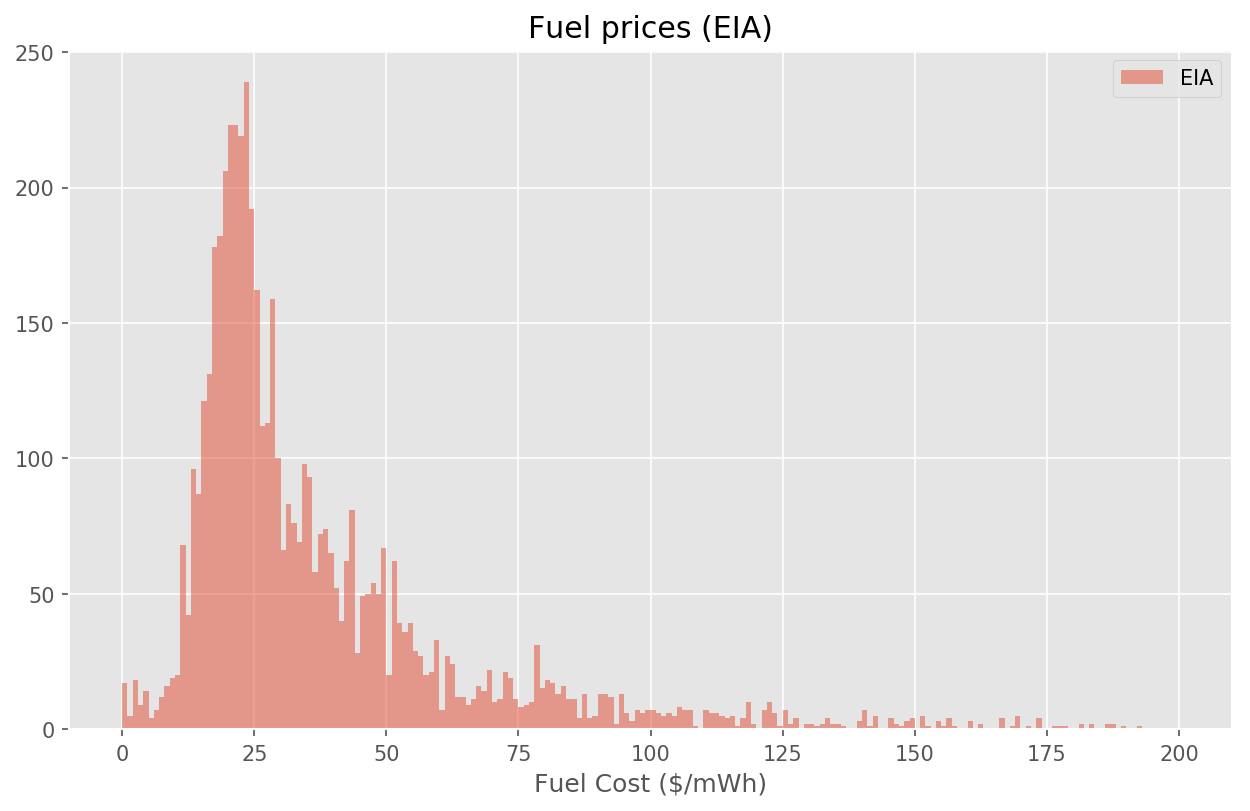

In [25]:
#quick look at spread in fuel_cost_per_mwh - how do we tell what's realistic?
plt.hist(mcoe_by_generator.fuel_cost_per_mwh, range=(0,200), bins=200, alpha=0.5, label="EIA");
plt.xlabel("Fuel Cost ($/mWh)");
plt.title("Fuel prices (EIA)")
plt.legend();

In [27]:
mcoe_by_generator.fuel_cost_per_mwh.describe()

count     5411.000000
mean        60.883408
std        804.107918
min      -1316.772911
25%         20.338544
50%         27.734643
75%         45.818050
max      50790.726912
Name: fuel_cost_per_mwh, dtype: float64

In [28]:
mcoe_annotations = pd.read_csv('mcoe_field_annotations.csv')

In [29]:
xlsx_writer = pd.ExcelWriter('EIA_mcoe_2011-2015.xlsx')
mcoe_by_generator.to_excel(xlsx_writer, sheet_name='MCOE by Generator', index=False)
mcoe_annotations.to_excel(xlsx_writer, sheet_name='MCOE Annotations', index=False)
xlsx_writer.save()